In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState

In [2]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv")
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv")
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv")
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv")

In [3]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)




In [4]:
datasets = [
    (X1_train, X1_test, y1_train, y1_test, "Bank"),
    (X2_train, X2_test, y2_train, y2_test, "Gym"),
    (X3_train, X3_test, y3_train, y3_test, "Heart Disease"),
    (X4_train, X4_test, y4_train, y4_test, "Titanic")
]
baseline_brier_scores = []


for X_train, X_test, y_train, y_test, _ in tqdm(datasets, desc="Processing datasets"):
    model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42)
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    baseline_brier_scores.append(brier)

for i, (brier, (_, _, _, _, dataset_name)) in enumerate(zip(baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Baseline Brier score = {brier:.4f}")

Processing datasets:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Dataset 1 (Bank): Baseline Brier score = 0.1893
Dataset 2 (Gym): Baseline Brier score = 0.1687
Dataset 3 (Heart Disease): Baseline Brier score = 0.0998
Dataset 4 (Titanic): Baseline Brier score = 0.1712


C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



### Random search optimization

In [5]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10           
ABS_TOL = 0.001 
CV = 5

In [6]:
pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', probability=True, random_state=42)
)
param_distributions = {
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-4, 1e1)
}
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=N_ITER,
    scoring=SCORER,
    cv=CV,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)
tuned_brier_scores = []
best_params_list = []
cv_results_list = []



In [7]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Brier per Random Search iteration and best-so-far for {dataset_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:
def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE):
    """
    Szuka pierwszego okna długości window_len takie, że wszystkie window_len-1 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window))
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None


Tuning datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


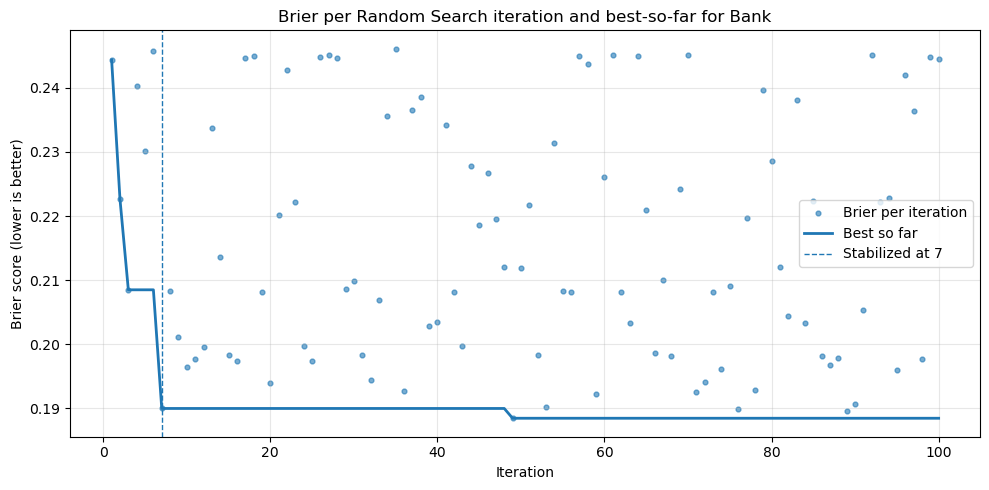

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


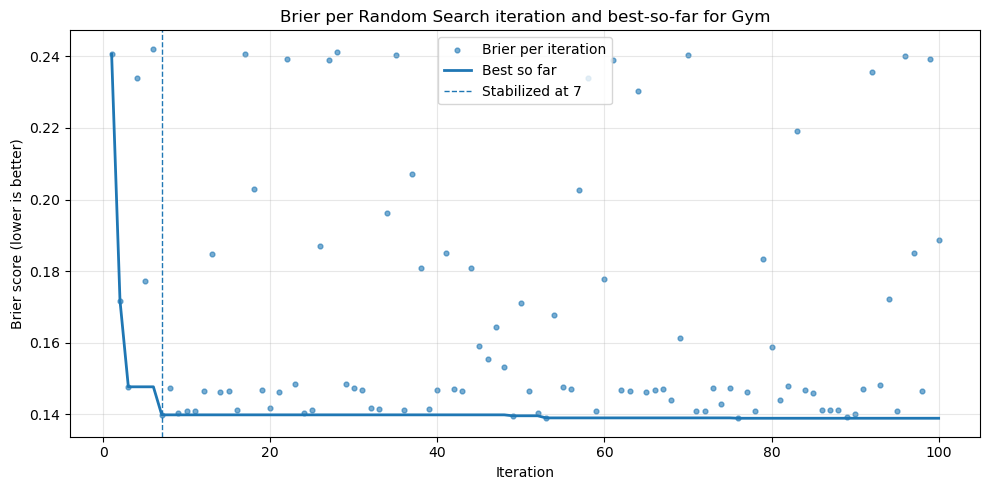

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


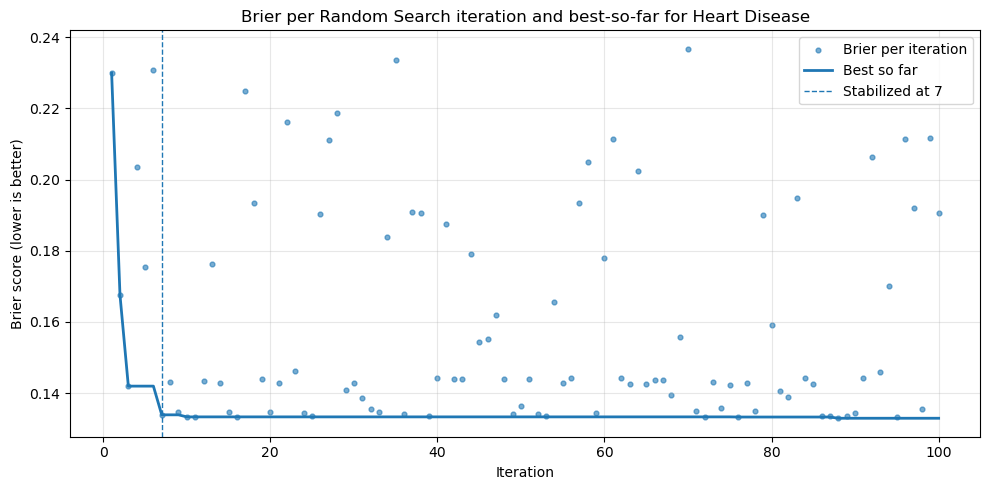

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micae\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


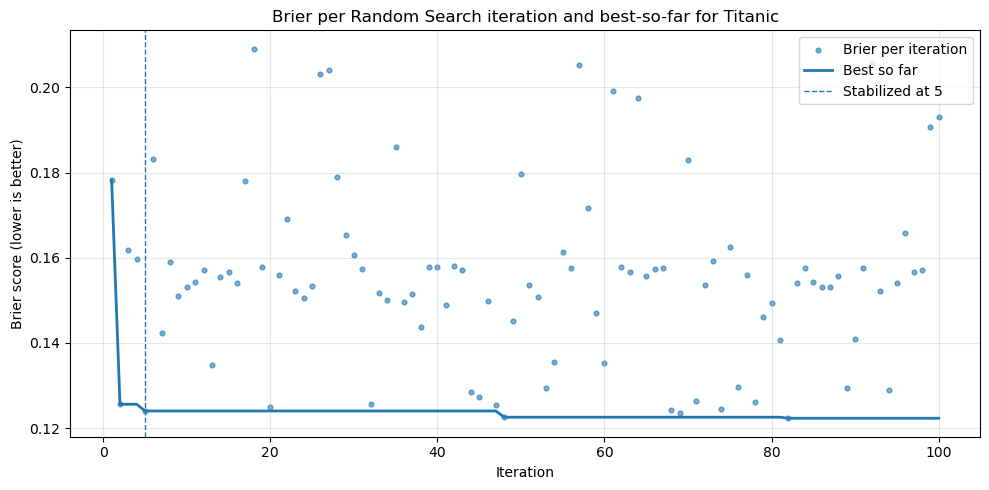

In [9]:
random_search_history = {
    "Bank": {"brier": [], "best_so_far": []},
    "Gym": {"brier": [], "best_so_far": []},
    "Heart Disease": {"brier": [], "best_so_far": []},
    "Titanic": {"brier": [], "best_so_far": []}
}
# noinspection PyTypeChecker
for X_train, X_test, y_train, y_test, dataset_name in tqdm(datasets, desc="Tuning datasets"):
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    best_params = {'C': best_params['svc__C'], 'gamma': best_params['svc__gamma']}

    model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42, **best_params)
    )
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_proba)
    tuned_brier_scores.append(brier)
    best_params_list.append(best_params)
    cv_results_list.append(random_search.cv_results_)

    # Extract CV results for visualization
    cv_results = random_search.cv_results_
    mean_test_scores = -cv_results['mean_test_score']
    best_so_far = np.minimum.accumulate(mean_test_scores)
    random_search_history[dataset_name]["brier"] = mean_test_scores.tolist()
    random_search_history[dataset_name]["best_so_far"] = best_so_far.tolist()
    param_C = cv_results['param_svc__C'].data
    param_gamma = cv_results['param_svc__gamma'].data
    mean_test_score = -cv_results['mean_test_score']  # Negate if using neg_log_loss
    best_so_far = np.minimum.accumulate(mean_test_score)

    # Detect stabilization
    stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len=WINDOW_SIZE)

    # Prepare data for plotting
    iters = np.arange(1, len(mean_test_score) + 1)
    brier_per_iter = mean_test_score  # Brier scores per iteration

    # Plot the results for this dataset
    chart_random(stabilized_at, brier_per_iter, iters, best_so_far, dataset_name)

In [10]:
for i, (brier, baseline_brier, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, baseline_brier_scores, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Tuned Brier score = {brier:.4f}, Baseline Brier score = {baseline_brier:.4f}")

Dataset 1 (Bank): Tuned Brier score = 0.1893, Baseline Brier score = 0.1893
Dataset 2 (Gym): Tuned Brier score = 0.1676, Baseline Brier score = 0.1687
Dataset 3 (Heart Disease): Tuned Brier score = 0.1086, Baseline Brier score = 0.0998
Dataset 4 (Titanic): Tuned Brier score = 0.1645, Baseline Brier score = 0.1712


In [11]:
for i, (brier, params, (_, _, _, _, dataset_name)) in enumerate(zip(tuned_brier_scores, best_params_list, datasets), 1):
    print(f"Dataset {i} ({dataset_name}): Tuned Brier score = {brier:.4f}, Best C = {params['C']:.4f}, Best gamma = {params['gamma']:.4f}")

Dataset 1 (Bank): Tuned Brier score = 0.1893, Best C = 1.3690, Best gamma = 0.0137
Dataset 2 (Gym): Tuned Brier score = 0.1676, Best C = 281.5758, Best gamma = 0.0016
Dataset 3 (Heart Disease): Tuned Brier score = 0.1086, Best C = 7.4308, Best gamma = 0.0007
Dataset 4 (Titanic): Tuned Brier score = 0.1645, Best C = 6.3267, Best gamma = 0.0477


## Optymalizacja Bayesowska

In [12]:
from sklearn.model_selection import StratifiedKFold


def bayes_optimize(X_loc, y_arr, n_trials=N_ITER, cv=CV, random_state=RANDOM_STATE, n_jobs_model=1, pruner_n_startup_trials=10):
    y_arr = y_arr.iloc[:,0].to_numpy().ravel()
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    sampler = optuna.samplers.TPESampler(seed=random_state)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=pruner_n_startup_trials, n_warmup_steps=0, interval_steps=1)
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

    def objective(trial):
        params = {
    'C': trial.suggest_float('C', 1e-3, 1e3, log=True),
    'gamma': trial.suggest_float('gamma', 1e-4, 1e1, log=True)
}

        model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', probability=True, random_state=42, **params)
    )

        neg_briers = []

        for fold_idx, (train_idx, val_idx) in enumerate(cv_splitter.split(X_loc, y_arr)):
            X_tr = X_loc.iloc[train_idx] 
            X_val = X_loc.iloc[val_idx]
            y_tr = y_arr[train_idx]
            y_val = y_arr[val_idx]

            model.fit(
                X_tr, y_tr
            )

            probs = model.predict_proba(X_val)[:, 1]
            neg_brier = -brier_score_loss(y_val, probs) 
            neg_briers.append(neg_brier)

            mean_neg_so_far = float(np.mean(neg_briers))
            trial.report(mean_neg_so_far, step=fold_idx)
            if trial.should_prune():
                raise optuna.TrialPruned()
            
        mean_neg = float(np.mean(neg_briers))
       
        return mean_neg
    
    study.optimize(objective, n_trials=n_trials)

    trials = study.trials
    neg_scores = [t.value if t.value is not None else np.nan for t in trials]
    brier_per_iter = -np.array(neg_scores, dtype=float)

    best_so_far = []
    current_best = np.inf
    for v in brier_per_iter:
        if np.isnan(v):
            best_so_far.append(current_best if current_best != np.inf else np.nan)
        else:
            if v < current_best:
                current_best = v
            best_so_far.append(current_best)
    best_so_far = np.array(best_so_far, dtype=float)

    completed = [t for t in trials if t.state == TrialState.COMPLETE and t.value is not None]
    best_trial = max(completed, key=lambda tr: tr.value)
    best_params = best_trial.params
    best_brier = float(best_trial.value)
    best_so_far = np.array(best_so_far, dtype=float)
    iters = np.arange(1, len(brier_per_iter) + 1)
    return {
        'brier_per_iter': brier_per_iter,
        'best_so_far': best_so_far,
        'best_params': best_params,
        'best_brier': best_brier
    }

In [13]:
result3 = bayes_optimize(X3_train, y3_train)


[I 2025-11-16 21:39:51,596] A new study created in memory with name: no-name-32f0c269-801f-4422-acdb-f093a59e5bbf
[I 2025-11-16 21:39:52,079] Trial 0 finished with value: -0.23146401135431857 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.23146401135431857.
[I 2025-11-16 21:39:52,422] Trial 1 finished with value: -0.1656761060139457 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.1656761060139457.
[I 2025-11-16 21:39:52,787] Trial 2 finished with value: -0.1437484069653741 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.1437484069653741.
[I 2025-11-16 21:39:53,208] Trial 3 finished with value: -0.20596455158844673 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.1437484069653741.
[I 2025-11-16 21:39:53,624] Trial 4 finished with value: -0.17220622543376712 and par

In [14]:
brier_per_iter = result3["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result3["best_so_far"]
result3["best_params"]


100


{'C': 2.577578399571691, 'gamma': 0.011829292836563672}

In [15]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


In [16]:
print(stabilized_at, stabilized_value)


7 0.1342781562636562


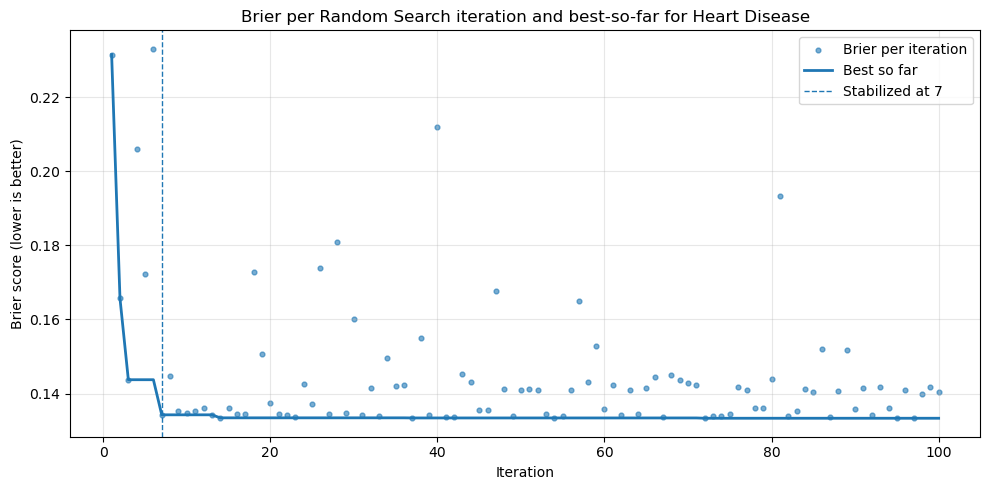

In [17]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="Heart Disease")


In [18]:
result1 = bayes_optimize(X1_train, y1_train)

[I 2025-11-16 21:40:09,789] A new study created in memory with name: no-name-41b76acf-c54b-4cad-b662-94c55e42d1bd
[I 2025-11-16 21:41:26,913] Trial 0 finished with value: -0.24438925173552759 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.24438925173552759.
[I 2025-11-16 21:42:42,794] Trial 1 finished with value: -0.2197920324828427 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.2197920324828427.
[I 2025-11-16 21:43:45,445] Trial 2 finished with value: -0.20810418713906048 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.20810418713906048.
[I 2025-11-16 21:44:45,458] Trial 3 finished with value: -0.24063937776836042 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.20810418713906048.
[I 2025-11-16 21:45:57,612] Trial 4 finished with value: -0.22858496295978706 and 

In [19]:
brier_per_iter = result1["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result1["best_so_far"]
result1["best_params"]

100


{'C': 4.177031028761628, 'gamma': 0.010251858324347664}

In [20]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


In [21]:
print(stabilized_at, stabilized_value)


7 0.1898212387838196


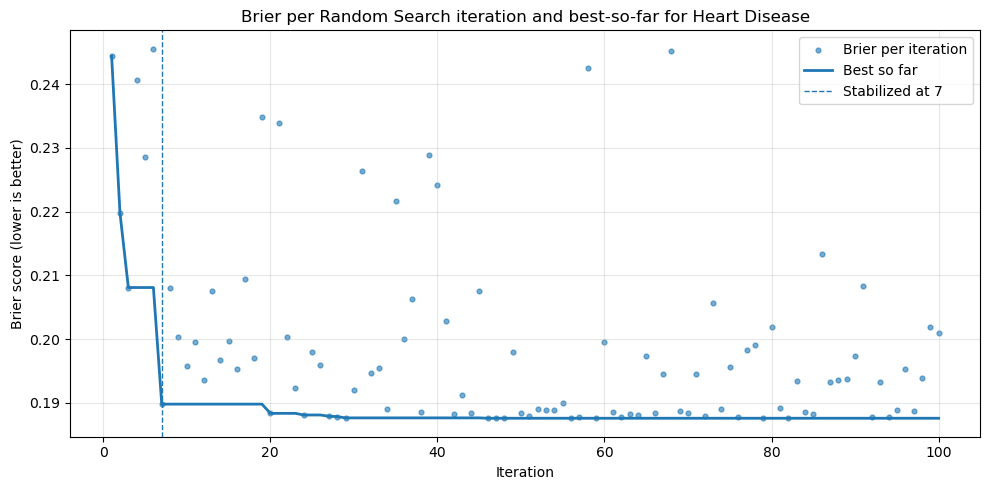

In [22]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="Heart Disease")


In [23]:
result2 = bayes_optimize(X2_train, y2_train)

[I 2025-11-16 22:43:29,732] A new study created in memory with name: no-name-840f38b6-c300-4f13-b41e-45914a886c4d
[I 2025-11-16 22:43:31,435] Trial 0 finished with value: -0.2405763318954663 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.2405763318954663.
[I 2025-11-16 22:43:32,844] Trial 1 finished with value: -0.17188104085996542 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.17188104085996542.
[I 2025-11-16 22:43:34,013] Trial 2 finished with value: -0.14839907249591683 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 2 with value: -0.14839907249591683.
[I 2025-11-16 22:43:35,493] Trial 3 finished with value: -0.23438348118150726 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 2 with value: -0.14839907249591683.
[I 2025-11-16 22:43:37,045] Trial 4 finished with value: -0.1764109610568773 and p

In [24]:
brier_per_iter = result2["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result2["best_so_far"]
result2["best_params"]

100


{'C': 1.927147263811625, 'gamma': 0.0158554887437458}

In [25]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


In [26]:
print(stabilized_at, stabilized_value)


7 0.14046794571429105


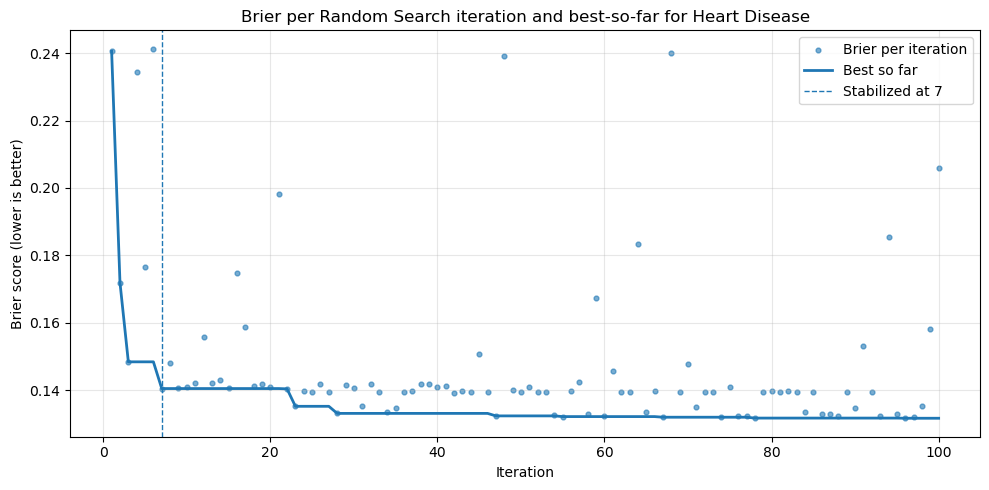

In [27]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="Heart Disease")


In [28]:
result4 = bayes_optimize(X4_train, y4_train)


[I 2025-11-16 22:44:36,466] A new study created in memory with name: no-name-cc88b2a4-d608-4a3d-9fbb-36c64a564d7a
[I 2025-11-16 22:44:36,770] Trial 0 finished with value: -0.1802820143183912 and parameters: {'C': 0.1767016940294795, 'gamma': 5.669849511478847}. Best is trial 0 with value: -0.1802820143183912.
[I 2025-11-16 22:44:37,005] Trial 1 finished with value: -0.13198079707333274 and parameters: {'C': 24.658329458549105, 'gamma': 0.09846738873614563}. Best is trial 1 with value: -0.13198079707333274.
[I 2025-11-16 22:44:37,253] Trial 2 finished with value: -0.16108274648159718 and parameters: {'C': 0.008632008168602538, 'gamma': 0.000602521573620386}. Best is trial 1 with value: -0.13198079707333274.
[I 2025-11-16 22:44:37,505] Trial 3 finished with value: -0.16319974396116133 and parameters: {'C': 0.002231010801867922, 'gamma': 2.1423021757741068}. Best is trial 1 with value: -0.13198079707333274.
[I 2025-11-16 22:44:37,738] Trial 4 finished with value: -0.1362300803139339 and p

In [29]:
brier_per_iter = result4["brier_per_iter"]
print(len(brier_per_iter))
best_so_far = result4["best_so_far"]
result4["best_params"]

100


{'C': 21.71388003863076, 'gamma': 0.021649610751383667}

In [30]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)


In [31]:
print(stabilized_at, stabilized_value)


2 0.13198079707333274


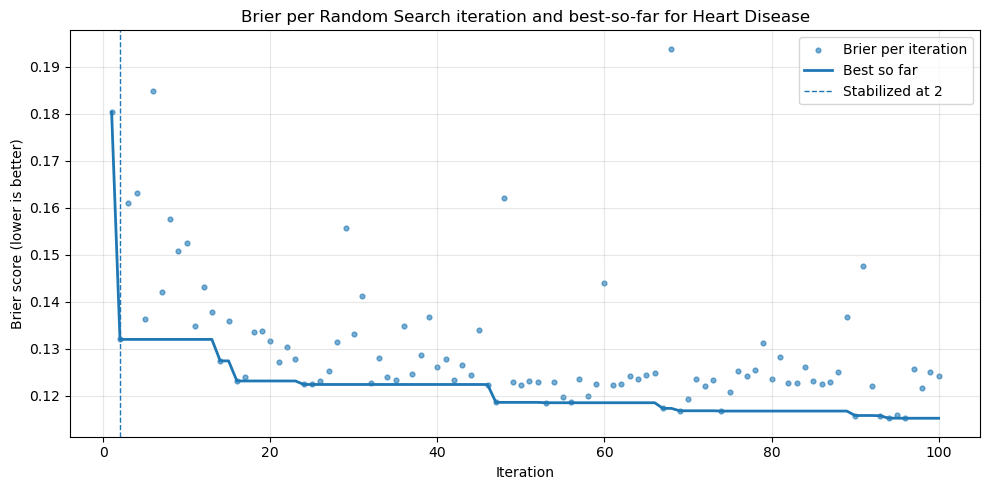

In [32]:
iters = np.arange(1, 101)
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, dataset_name="Heart Disease")


In [33]:
def plot_comparison(dataset_name):
    plt.figure(figsize=(12, 6))

    # Random Search
    random_data = random_search_history[dataset_name]
    plt.plot(range(1, len(random_data["best_so_far"]) + 1),
             random_data["best_so_far"],
             label='Best-so-far Random',
             color='orange',
             linewidth=2,
             alpha=0.7)

    # Bayes Search
    result_map = {
        "Bank": result1,
        "Gym": result2,
        "Heart Disease": result3,
        "Titanic": result4
    }
    bayes_data = result_map[dataset_name]
    plt.plot(range(1, len(bayes_data["best_so_far"]) + 1),
             bayes_data["best_so_far"],
             label='Best-so-far Bayes',
             color='blue',
             linewidth=2,
             alpha=0.7)

    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Comparison of best-so-far Brier scores: Bayes vs Random ({dataset_name})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

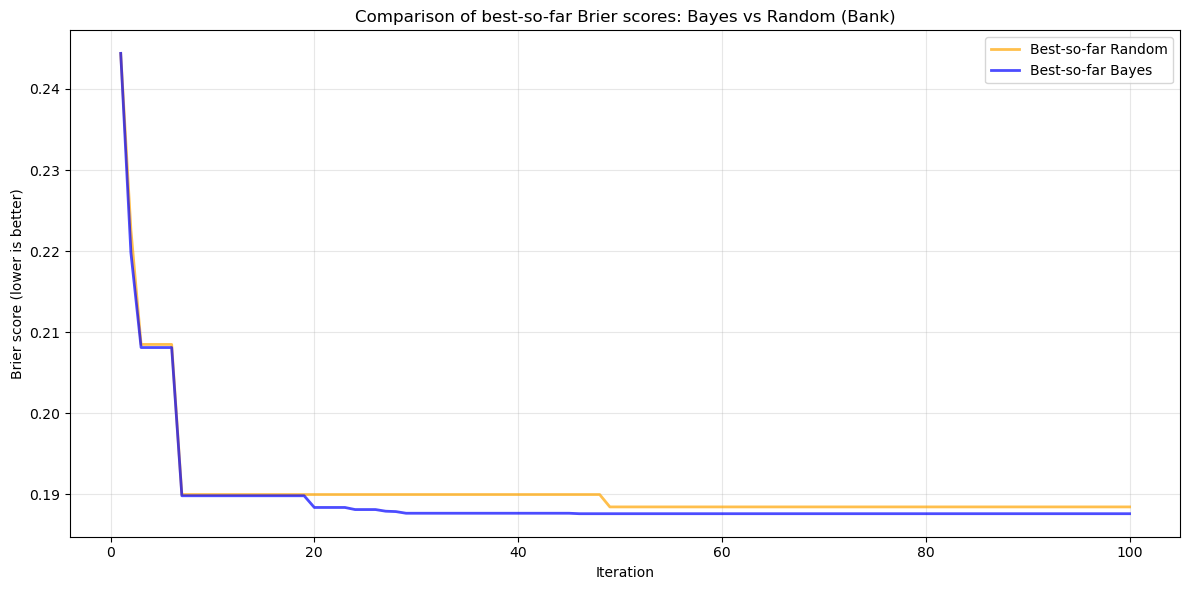

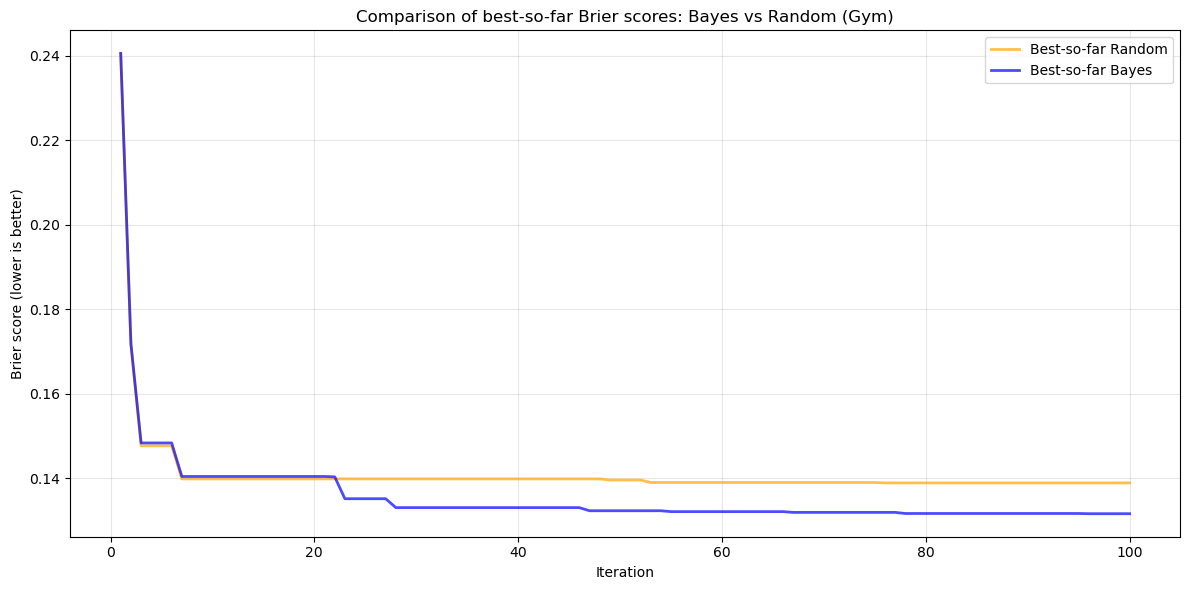

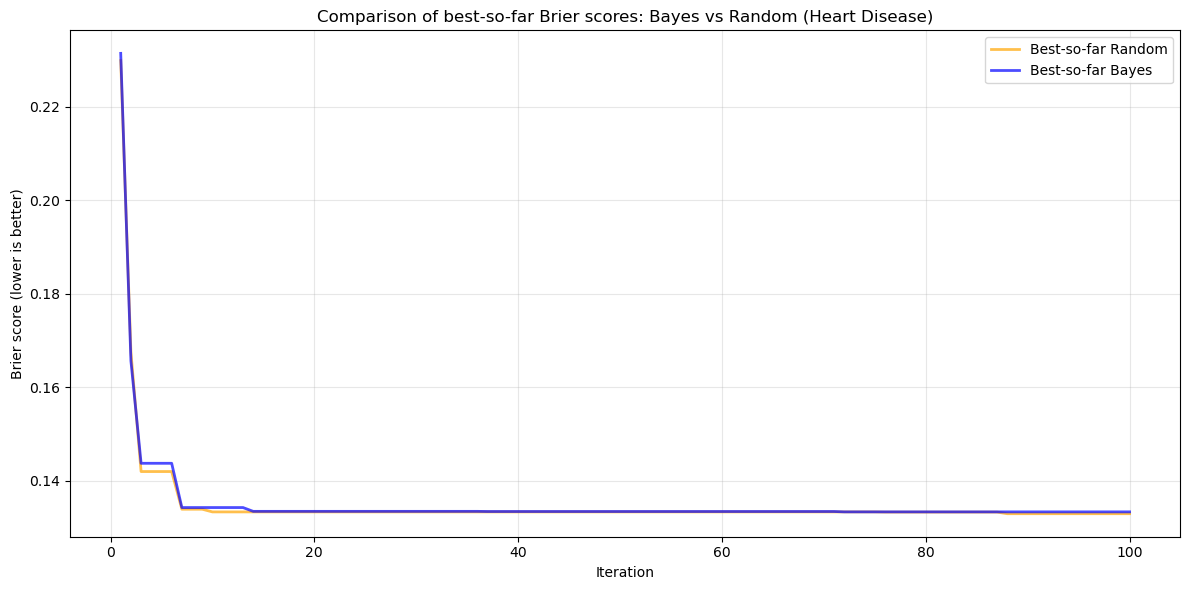

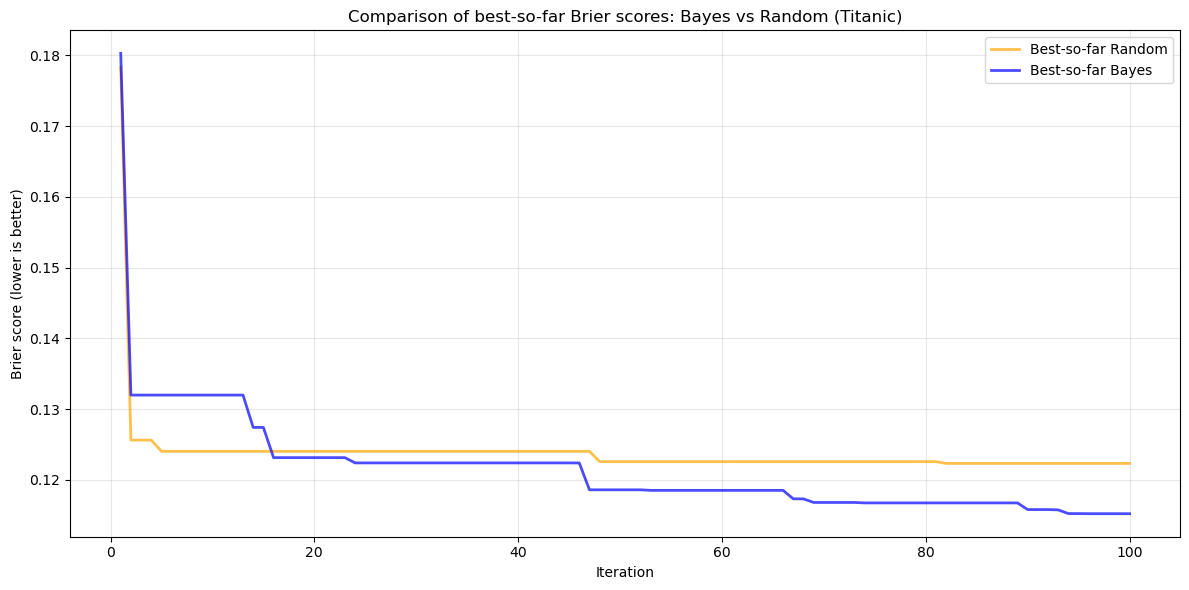

In [34]:
# Porównanie dla każdego zbioru danych
for dataset_name in ["Bank", "Gym", "Heart Disease", "Titanic"]:
    plot_comparison(dataset_name)

In [35]:
data = {
    "model": ["SVM"] * 4,
    "dataset": ["Bank", "Gym", "Heart", "Titanic"],
    "Params_Random": [
        {'C': 1.3690, 'gamma': 0.0137},
        {'C': 281.5758, 'gamma': 0.0016},
        {'C': 8.9570, 'gamma': 0.0007},
        {'C': 6.3267, 'gamma': 0.0477}
    ],
    "Brier_score_Base": [0.1893, 0.1687, 0.0998, 0.1712],
    "Brier_Random": [0.1893, 0.1676, 0.1085, 0.1645],
    "Bayes_Brier": [
        0.1876086998390129,
        0.13921661003418287,
        0.13328436116417486,
        0.12212406619348962
    ],
    "Bayes_Params": [
        {'C': 3.6224920477262006, 'gamma': 0.011434496347157295},
        {'C': 1.927147263811625, 'gamma': 0.0158554887437458},
        {'C': 1.2891930984694402, 'gamma': 0.022762273797099865},
        {'C': 21.71388003863076, 'gamma': 0.021649610751383667}
    ]
}

# Tworzymy DataFrame
df = pd.DataFrame(data)

# Obliczenia różnic względem wartości bazowej
df["Δ_Random_abs"] = df["Brier_Random"] - df["Brier_score_Base"]
df["Δ_Bayes_abs"] = df["Bayes_Brier"] - df["Brier_score_Base"]

df["Δ_Random_rel"] = df["Δ_Random_abs"] / df["Brier_score_Base"]
df["Δ_Bayes_rel"] = df["Δ_Bayes_abs"] / df["Brier_score_Base"]

df["Δ_Random_%"] = df["Δ_Random_rel"] * 100
df["Δ_Bayes_%"] = df["Δ_Bayes_rel"] * 100

# Zaokrąglamy dla czytelności
df = df.round(4)

df


,model,dataset,Params_Random,Brier_score_Base,Brier_Random,Bayes_Brier,Bayes_Params,Δ_Random_abs,Δ_Bayes_abs,Δ_Random_rel,Δ_Bayes_rel,Δ_Random_%,Δ_Bayes_%
0,SVM,Bank,"{'C': 1.369, 'gamma': 0.0137}",0.1893,0.1893,0.1876,"{'C': 3.6224920477262006, 'gamma': 0.011434496...",0.0000,-0.0017,0.0000,-0.0089,0.0000,-0.8934
1,SVM,Gym,"{'C': 281.5758, 'gamma': 0.0016}",0.1687,0.1676,0.1392,"{'C': 1.927147263811625, 'gamma': 0.0158554887...",-0.0011,-0.0295,-0.0065,-0.1748,-0.6520,-17.4768
2,SVM,Heart,"{'C': 8.957, 'gamma': 0.0007}",0.0998,0.1085,0.1333,"{'C': 1.2891930984694402, 'gamma': 0.022762273...",0.0087,0.0335,0.0872,0.3355,8.7174,33.5515
3,SVM,Titanic,"{'C': 6.3267, 'gamma': 0.0477}",0.1712,0.1645,0.1221,"{'C': 21.71388003863076, 'gamma': 0.0216496107...",-0.0067,-0.0491,-0.0391,-0.2867,-3.9136,-28.6658
